In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import os
import glob
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, plot_roc_curve
# pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
# !pip install graphviz
# !pip install pydotplus
# conda install graphviz
from six import StringIO
from sklearn import metrics

# # Data Preparation:

### 1. Data Creation

#### # Creating empty main csv file with all features name

In [2]:
df_main1 = pd.DataFrame(columns = ['name' ,'activity' ,'weight', 'duration','start_time' ,'change_in_load', 'variance',  'maximum', 'median', 'skewness', 'kurtosis', '0.9_quantile', 'acceleration', 'jerk', 'velocity', 'energy', 'power', 'momentum'])
df_main1

,name,activity,weight,duration,start_time,change_in_load,variance,maximum,median,skewness,kurtosis,0.9_quantile,acceleration,jerk,velocity,energy,power,momentum


#### # Creating a function of value incertion in main csv file

In [3]:
def value_insertion(loc_csv):
    df=pd.read_csv(loc_csv)
#     print(loc_csv)    # Print this if you want to track which folder is running while running the code
    df_main1.loc[len(df_main1.index)] = [df['name'][0], df['activity'][0], df['weight'][0], df['timestamp'][len(df)-1], df['start_time'][0], df['diff_load_sum'].mean(), df['diff_load_sum'].var(), df['diff_load_sum'].max(), df['diff_load_sum'].median(), df['diff_load_sum'].skew(), df['diff_load_sum'].kurtosis(), df['diff_load_sum'].quantile(0.9), df['acc'].mean(), df['jerk'].mean(), df['velo'].mean(), df['enr'].mean(), df['power'].mean(), df['mom'].mean()]
    return df_main1

#### # Creating a list with all folder's name

In [4]:
rootdir = "D:/Ajit/pip/sample_labeled9"
folder_list = []
for subdir, dirs, files in os.walk(rootdir):
    folder_list.append(subdir)
del folder_list[0]

#### # Value insertion in main csv file

In [5]:
i=0
for folder in folder_list:
    path=folder
    for filename in os.listdir(path):
        x=path+'/'+filename
#         print(i)    # Print this if you want to track which folder is running while running the code
        value_insertion(x)
        i+=1

In [100]:
# Taking backup of loaded dataset as 'df_main1'
df_main=df_main1.copy()

#### # Rows with only 'Urination' and 'Defication'

In [101]:
df_main=df_main[df_main['activity']!='non_elimination']

In [102]:
df_main.shape

(8929, 18)

### 2. Data cleaning and Outlier removal

In [103]:
# Replacing NaN Name as 'unknown'
df_main['name'].fillna('unknown',inplace=True)

# Dropping NaN Rows 
df_main.dropna(inplace=True)

# Dropping rows with weight less than 1kg and more than 8kg
df_main=df_main[(df_main['weight']>1000) & (df_main['weight']<8000)]

# Activity "duration" 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['duration']>450))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['duration']>400))]

# "Change in load" 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['change_in_load']>1.8))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['change_in_load']>1.5))]

# 'Variance' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['variance']>8))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['variance']>7))]

# 'Skewness' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['skewness']>10))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['skewness']>12))]

# 'Acceleration' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['acceleration']>0.41))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['acceleration']>0.34))]

# 'Jerk' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['jerk']>7))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['jerk']>5.8))]

# 'Velocity'
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['velocity']>45))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['velocity']>34))]

# 'Energy' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['energy']>5000))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['energy']>3000))]

# 'Power' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['power']>47))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['power']>27))]

# 'Momentum' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['momentum']>195))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['momentum']>135))]

df_main=df_main[~((df_main['activity']=='defecation') & (df_main['energy']>4500))]

df_main.shape

(8785, 18)

### 3. Final Data

In [104]:
# Onehot encoding
df_main=pd.get_dummies(df_main, columns=['activity'])

# Droping non numeric columns
df_main.drop(['name', 'start_time', 'activity_defecation'], axis=1, inplace=True)

# Dropping 'Weight' column as there are no variation shown across activities in boxplot of final EDA
df_main.drop(['weight'], axis=1, inplace=True)

### Deleting 'kurtosis', 'variance', 'maximum', 'velocity', '0.9_quantile' columns as a result of Backward elimination in modelling
df_main.drop(['kurtosis', 'variance', 'maximum', 'velocity', '0.9_quantile'], axis=1, inplace=True)
df_main.head()

,duration,change_in_load,median,skewness,acceleration,jerk,energy,power,momentum,activity_urination
0,163.975000,1.114670,0.43164,2.088879,0.160777,2.623752,1422.404601,14.699895,129.161654,0
1,204.774940,0.996088,0.32373,2.502551,0.154408,2.854197,1626.238512,15.753942,129.217548,0
2,59.975000,0.292591,0.05886,2.892435,0.040413,0.638543,13.463229,0.355113,12.974780,0
3,156.775000,0.952895,0.23544,2.385345,0.133758,2.379447,898.360000,9.996573,101.825709,0
4,183.974939,1.174555,0.14715,2.486553,0.164273,2.929181,2029.562636,17.758225,153.431382,0


In [105]:
df_main.columns

Index(['duration', 'change_in_load', 'median', 'skewness', 'acceleration',
       'jerk', 'energy', 'power', 'momentum', 'activity_urination'],
      dtype='object')

### 4. Upsampling

In [106]:
df_majority = df_main[df_main.activity_urination==1]
df_minority = df_main[df_main.activity_urination==0]

df_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=0)

df_main = pd.concat([df_majority, df_upsampled])

# # Modelling

### Data splitting to train, test and validation

In [107]:
df_shuffeled=df_main.sample(frac=1,random_state=101)

df_train=df_shuffeled[:int(len(df_shuffeled)*0.6)]
df_validate=df_shuffeled[int(len(df_shuffeled)*.6):int(len(df_shuffeled)*0.8)]
df_test=df_shuffeled[int(len(df_shuffeled)*0.8):]


x_train = df_train.drop(columns='activity_urination')
y_train = df_train['activity_urination']

x_validate = df_validate.drop(columns='activity_urination')
y_validate = df_validate['activity_urination']

x_test = df_test.drop(columns='activity_urination')
y_test = df_test['activity_urination']

### Modelling Using Random Forest (Best performance)

In [108]:
def error_metrics(actual, predicted, x_data):
    print('Accuracy %age: ' + str(np.round(accuracy_score(actual, predicted)*100,2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, classifier.predict_proba(x_data)[:,1]),2)))
    print('\nClassification Report: ')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix: ')
    print(confusion_matrix(actual, predicted))
    return 'Done'

#### Training Set

In [109]:
classifier = RandomForestClassifier(n_estimators=55, criterion='entropy',max_depth =35, random_state=10)
classifier.fit(x_train, y_train)

print('\nTraining\n--------------------------')
y_train_pred=classifier.predict(x_train)
error_metrics(y_train, y_train_pred, x_train)


Training
--------------------------
Accuracy %age: 99.99
ROC-AUC Score: 1.0

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3938
           1       1.00      1.00      1.00      3898

    accuracy                           1.00      7836
   macro avg       1.00      1.00      1.00      7836
weighted avg       1.00      1.00      1.00      7836


Confusion Matrix: 
[[3937    1]
 [   0 3898]]


'Done'

#### Validation Set

In [110]:
print('\nValidation\n--------------------------')
y_validate_pred=classifier.predict(x_validate)
error_metrics(y_validate, y_validate_pred, x_validate)


Validation
--------------------------
Accuracy %age: 91.16
ROC-AUC Score: 0.97

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1315
           1       0.96      0.86      0.91      1297

    accuracy                           0.91      2612
   macro avg       0.92      0.91      0.91      2612
weighted avg       0.92      0.91      0.91      2612


Confusion Matrix: 
[[1267   48]
 [ 183 1114]]


'Done'

#### Test Set

In [111]:
print('\nTesting\n--------------------------')
y_test_pred=classifier.predict(x_test)
error_metrics(y_test, y_test_pred, x_test)


Testing
--------------------------
Accuracy %age: 91.16
ROC-AUC Score: 0.97

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1277
           1       0.95      0.87      0.91      1335

    accuracy                           0.91      2612
   macro avg       0.91      0.91      0.91      2612
weighted avg       0.91      0.91      0.91      2612


Confusion Matrix: 
[[1216   61]
 [ 170 1165]]


'Done'

### Feature Importance

In [112]:
df_importance = pd.DataFrame()
df_importance['Features'] = x_test.columns
df_importance['Importance'] = classifier.feature_importances_
df_importance = df_importance.sort_values(by='Importance', ascending=False).reset_index(drop=True)
df_importance

,Features,Importance
0,energy,0.163581
1,duration,0.144656
2,momentum,0.138884
3,power,0.128892
4,jerk,0.119468
5,median,0.081242
6,change_in_load,0.078454
7,skewness,0.075762
8,acceleration,0.069062


<AxesSubplot: xlabel='Importance', ylabel='Features'>

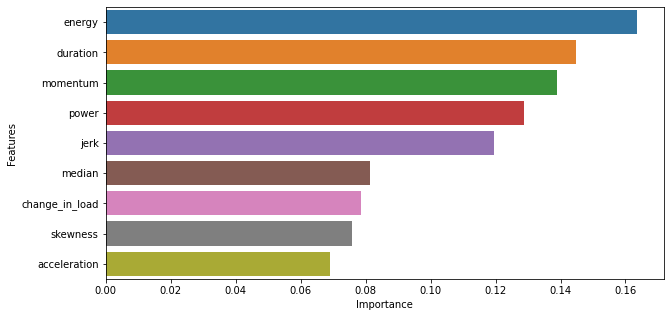

In [113]:
plt.figure(figsize = (10,5))
sns.barplot(x = 'Importance', y = 'Features', data = df_importance)

# # Residual Analysis

### Using Random Forest for Test set

In [20]:
df_main.head()

,duration,change_in_load,median,skewness,acceleration,jerk,energy,power,momentum,activity_urination
35,151.974936,0.411415,0.02943,4.937878,0.062440,1.115698,231.485587,1.955160,53.699365,1
36,116.775000,0.513934,0.07848,3.543928,0.072436,1.317930,158.393776,2.175610,44.029496,1
37,103.974932,0.341989,0.07848,4.428555,0.053120,0.932406,56.504102,0.945586,24.531578,1
38,127.974931,0.378627,0.04905,4.008613,0.052726,0.902825,87.010054,1.278722,30.800858,1
39,134.374941,0.438349,0.03924,2.971821,0.068556,1.138041,157.388436,2.020651,39.991409,1


In [21]:
classifier = RandomForestClassifier(n_estimators=55, criterion='entropy',max_depth =35, random_state=10)
classifier.fit(x_train, y_train)

print('\nTesting\n--------------------------')
y_test_pred=classifier.predict(x_test)
error_metrics(y_test, y_test_pred, x_test)


Testing
--------------------------
Accuracy %age: 91.16
ROC-AUC Score: 0.97

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1277
           1       0.95      0.87      0.91      1335

    accuracy                           0.91      2612
   macro avg       0.91      0.91      0.91      2612
weighted avg       0.91      0.91      0.91      2612


Confusion Matrix: 
[[1216   61]
 [ 170 1165]]


'Done'

### 1. Falsely identified as Defecation (False_0)

#### Number of Rows misidentified as Defecation

In [22]:
False_0 = x_test[(y_test == 1) & (y_test_pred[:].T == 0)]
False_0.shape

(170, 9)

In [23]:
df_main.columns

Index(['duration', 'change_in_load', 'median', 'skewness', 'acceleration',
       'jerk', 'energy', 'power', 'momentum', 'activity_urination'],
      dtype='object')

#### Features average value for 'Urination'

In [24]:
df_main_urination=df_main[df_main['activity_urination']==1]
urination_mean=df_main_urination[['duration', 'change_in_load', 'median', 'skewness', 'acceleration',
       'jerk', 'energy', 'power', 'momentum']].mean()
urination_mean

duration          112.532604
change_in_load      0.538491
median              0.226917
skewness            4.966353
acceleration        0.112286
jerk                1.800631
energy            234.220964
power               4.028411
momentum           37.421950
dtype: float64

#### Features average value for 'Defication'

In [25]:
df_main_defecation=df_main[df_main['activity_urination']==0]
defecation_mean=df_main_defecation[['duration', 'change_in_load', 'median', 'skewness', 'acceleration',
       'jerk', 'energy', 'power', 'momentum']].mean()
defecation_mean

duration          165.516246
change_in_load      0.755342
median              0.368661
skewness            4.051674
acceleration        0.156251
jerk                2.677805
energy            828.667140
power              10.859759
momentum           72.144089
dtype: float64

#### Features average values for urination misidentified as defecation

In [26]:
False_0_mean=False_0[['duration', 'change_in_load', 'median', 'skewness', 'acceleration',
       'jerk', 'energy', 'power', 'momentum']].mean()
False_0_mean

duration          165.475506
change_in_load      0.666322
median              0.301052
skewness            4.137113
acceleration        0.135600
jerk                2.356729
energy            612.586664
power               7.995216
momentum           63.849994
dtype: float64

#### Table of Feature's mean

In [27]:
data = {"Urination": urination_mean,
        "Defecation": defecation_mean,
        "Misidentified_as_defecation": False_0_mean}
df_mean = pd.concat(data,axis = 1)
df_mean

,Urination,Defecation,Misidentified_as_defecation
duration,112.532604,165.516246,165.475506
change_in_load,0.538491,0.755342,0.666322
median,0.226917,0.368661,0.301052
skewness,4.966353,4.051674,4.137113
acceleration,0.112286,0.156251,0.135600
jerk,1.800631,2.677805,2.356729
energy,234.220964,828.667140,612.586664
power,4.028411,10.859759,7.995216
momentum,37.421950,72.144089,63.849994


#### ( Those Urination has features values nearer to the Defecation values are misidentifier as Defecation )

#### Box plots of Urination misidentified as defecation

In [28]:
False_0_box = False_0[['duration', 'change_in_load', 'skewness', 'acceleration', 'jerk', 'energy', 'power','momentum']]
False_0_box.columns

Index(['duration', 'change_in_load', 'skewness', 'acceleration', 'jerk',
       'energy', 'power', 'momentum'],
      dtype='object')

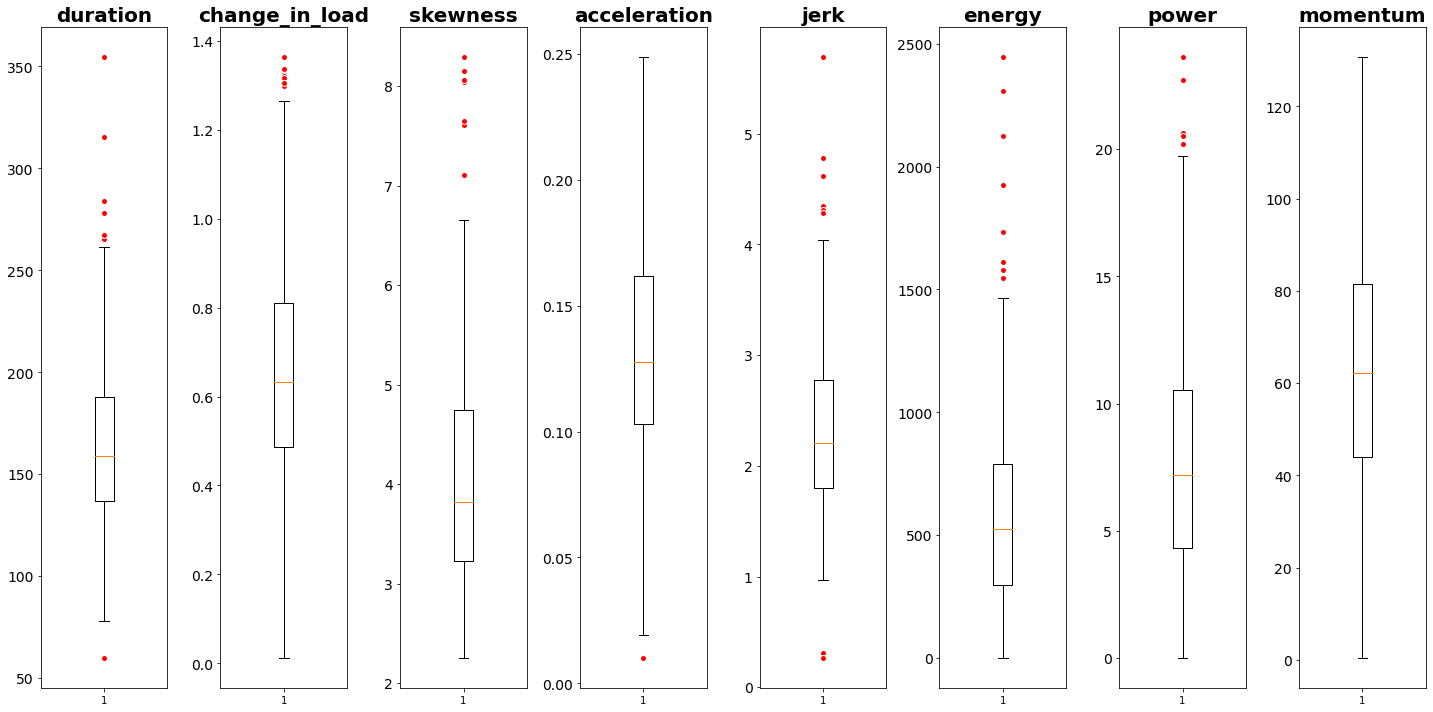

In [29]:
#Creating subplot of each column with its own scale

red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(False_0_box.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(False_0_box.iloc[:,i], flierprops=red_circle)
    ax.set_title(False_0_box.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

### 2. Falsely identified as Urination (False_1)

#### Number of Rows misidentified as Urination

In [30]:
False_1 = x_test[(y_test == 0) & (y_test_pred[:].T == 1)]
False_1.shape

(61, 9)

#### Features average value for 'Defication'

In [31]:
df_main_defecation=df_main[df_main['activity_urination']==0]
df_main_defecation[['duration', 'change_in_load', 'median', 'skewness', 'acceleration',
       'jerk', 'energy', 'power', 'momentum']].mean()

duration          165.516246
change_in_load      0.755342
median              0.368661
skewness            4.051674
acceleration        0.156251
jerk                2.677805
energy            828.667140
power              10.859759
momentum           72.144089
dtype: float64

#### Features average values for Defication misidentified as Urination

In [32]:
False_1[['duration', 'change_in_load', 'median', 'skewness', 'acceleration',
       'jerk', 'energy', 'power', 'momentum']].mean()

duration          132.319110
change_in_load      0.479114
median              0.138948
skewness            4.571705
acceleration        0.093733
jerk                1.654049
energy            254.740012
power               3.401472
momentum           42.212665
dtype: float64

#### Box plots of Defecation misidentified as Urination

In [33]:
False_1_box = False_1[['duration', 'change_in_load', 'skewness', 'acceleration', 'jerk', 'energy', 'power','momentum']]
False_1_box.columns

Index(['duration', 'change_in_load', 'skewness', 'acceleration', 'jerk',
       'energy', 'power', 'momentum'],
      dtype='object')

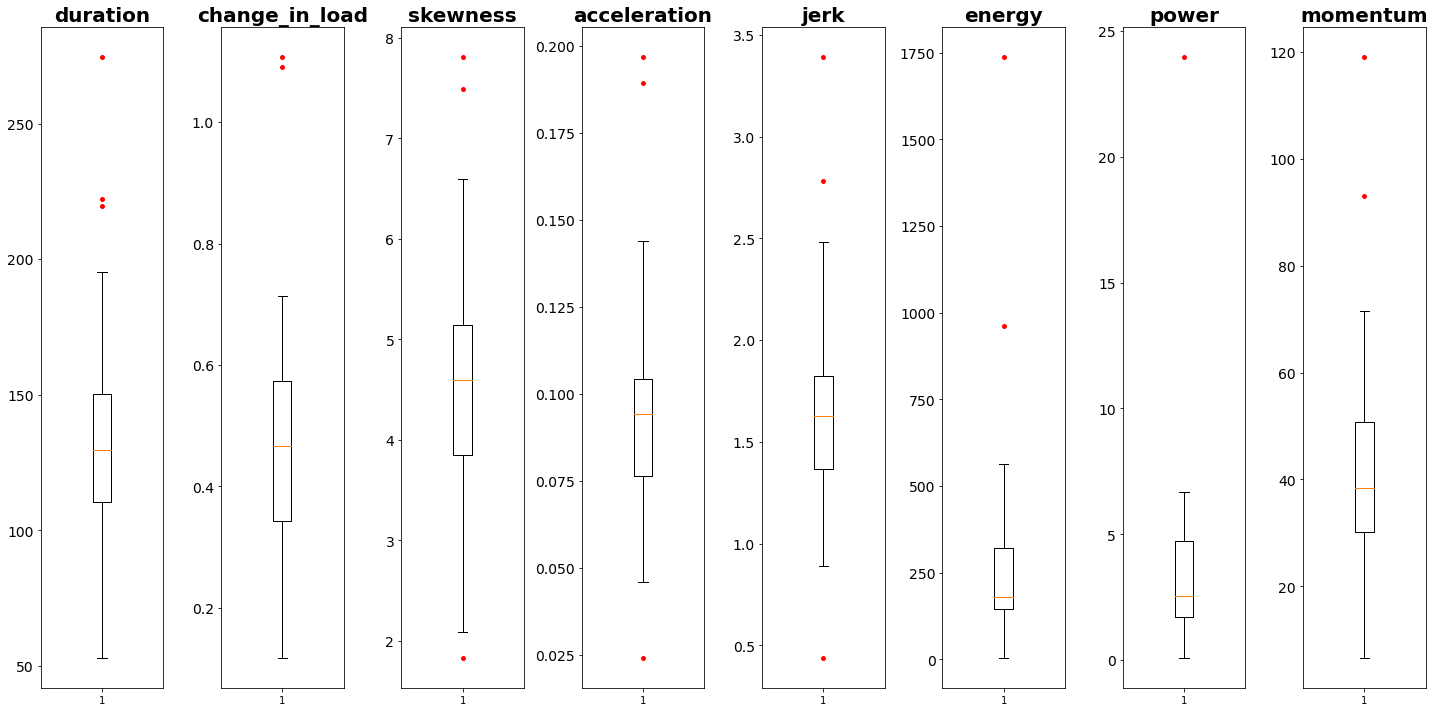

In [34]:
#Creating subplot of each column with its own scale

red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(False_1_box.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(False_1_box.iloc[:,i], flierprops=red_circle)
    ax.set_title(False_1_box.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

In [35]:
False_1_box.shape

(61, 8)

### Removing 3 outlier rows from 61 rows

In [36]:
# "Change in load" 
False_1_box=False_1_box[False_1_box['change_in_load']<1]


# 'Energy' 
False_1_box=False_1_box[False_1_box['energy']<960]


False_1_box.shape

(58, 8)

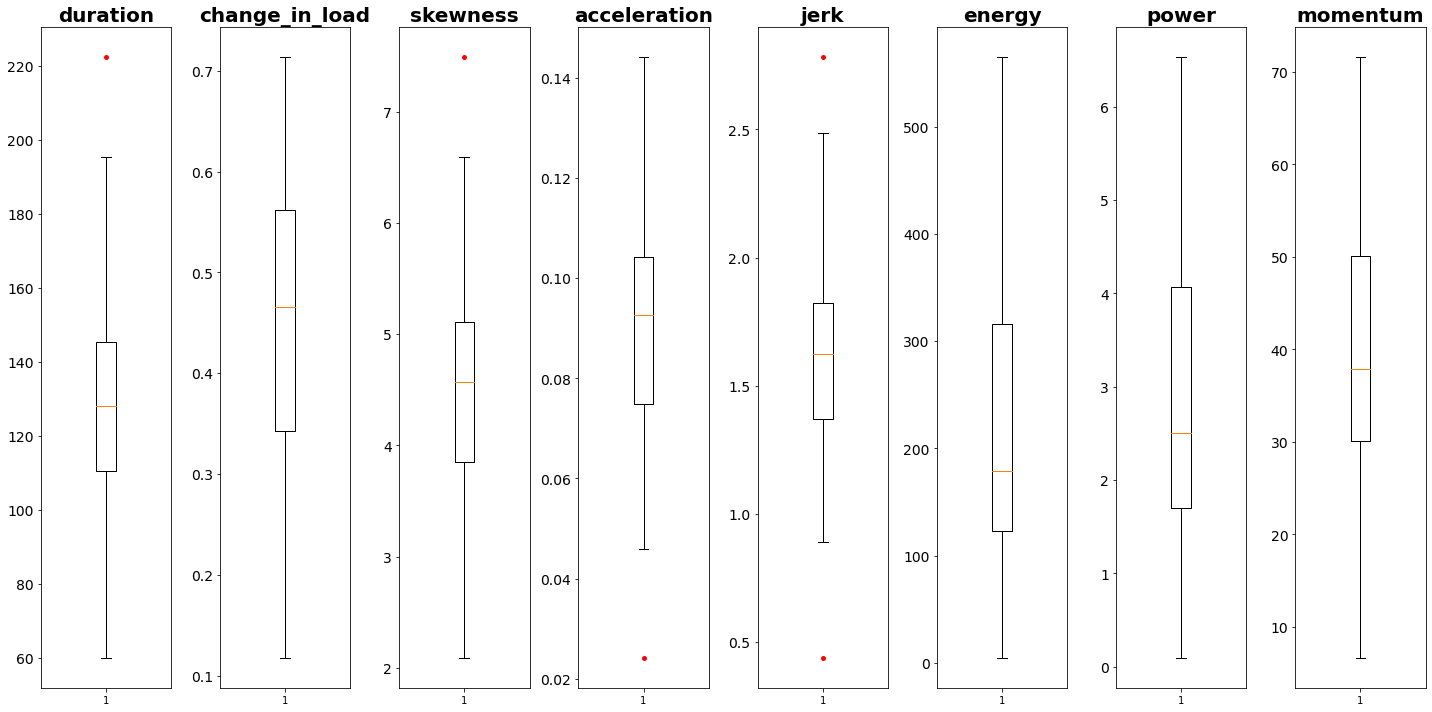

In [37]:
#Creating subplot of each column with its own scale

red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(False_1_box.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(False_1_box.iloc[:,i], flierprops=red_circle)
    ax.set_title(False_1_box.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

#### Features average value for 'Defication'

In [38]:
df_main_defecation=df_main[df_main['activity_urination']==0]
defecation_mean=df_main_defecation[['duration', 'change_in_load', 'median', 'skewness', 'acceleration',
       'jerk', 'energy', 'power', 'momentum']].mean()
defecation_mean

duration          165.516246
change_in_load      0.755342
median              0.368661
skewness            4.051674
acceleration        0.156251
jerk                2.677805
energy            828.667140
power              10.859759
momentum           72.144089
dtype: float64

#### Features average value for 'Urination'

In [39]:
df_main_defecation=df_main[df_main['activity_urination']==1]
urination_mean=df_main_defecation[['duration', 'change_in_load', 'median', 'skewness', 'acceleration',
       'jerk', 'energy', 'power', 'momentum']].mean()
urination_mean

duration          112.532604
change_in_load      0.538491
median              0.226917
skewness            4.966353
acceleration        0.112286
jerk                1.800631
energy            234.220964
power               4.028411
momentum           37.421950
dtype: float64

#### Features average values for Defication misidentified as Urination

In [40]:
False_1=False_1[False_1['change_in_load']<1]
False_1=False_1[False_1['energy']<960]

False_1_mean=False_1[['duration', 'change_in_load', 'median', 'skewness', 'acceleration',
       'jerk', 'energy', 'power', 'momentum']].mean()
False_1_mean

duration          129.734578
change_in_load      0.457096
median              0.115183
skewness            4.548847
acceleration        0.090299
jerk                1.636049
energy            218.698001
power               2.955174
momentum           40.090914
dtype: float64

#### Table of Feature's mean

In [41]:
data = {"Urination": urination_mean,
        "Defecation": defecation_mean,
        "Misidentified_as_urination": False_1_mean}
df_mean = pd.concat(data,axis = 1)
df_mean

,Urination,Defecation,Misidentified_as_urination
duration,112.532604,165.516246,129.734578
change_in_load,0.538491,0.755342,0.457096
median,0.226917,0.368661,0.115183
skewness,4.966353,4.051674,4.548847
acceleration,0.112286,0.156251,0.090299
jerk,1.800631,2.677805,1.636049
energy,234.220964,828.667140,218.698001
power,4.028411,10.859759,2.955174
momentum,37.421950,72.144089,40.090914


#### ( Those defecation has features value nearer to urination values are misidentified as urination )

# # Improvement of Model Performance

### # Introducing 'load/sec' to improve the performance 

In [82]:
df_main=df_main1.copy()

In [84]:
df_main=df_main[df_main['activity']!='non_elimination']
df_main.shape

(8929, 18)

In [85]:
df_main['load_change/sec']=df_main['change_in_load']/df_main['duration']

In [86]:
### Data cleaning & Outlier Treatment:

# Replacing NaN Name as 'unknown'
df_main['name'].fillna('unknown',inplace=True)

# Dropping NaN Rows 
df_main.dropna(inplace=True)

# Dropping rows with weight less than 1kg and more than 8kg
df_main=df_main[(df_main['weight']>1000) & (df_main['weight']<8000)]

# Activity "duration" 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['duration']>450))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['duration']>400))]

# "Change in load" 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['change_in_load']>1.8))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['change_in_load']>1.5))]

# 'Variance' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['variance']>8))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['variance']>7))]

# 'Skewness' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['skewness']>10))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['skewness']>12))]

# 'Acceleration' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['acceleration']>0.41))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['acceleration']>0.34))]

# 'Jerk' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['jerk']>7))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['jerk']>5.8))]

# 'Velocity'
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['velocity']>45))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['velocity']>34))]

# 'Energy' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['energy']>5000))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['energy']>3000))]

# 'Power' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['power']>47))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['power']>27))]

# 'Momentum' 
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['momentum']>195))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['momentum']>135))]

df_main=df_main[~((df_main['activity']=='defecation') & (df_main['energy']>4500))]

df_main.shape

(8785, 19)

In [87]:
# Onehot encoding
df_main=pd.get_dummies(df_main, columns=['activity'])

# Droping non numeric columns
df_main.drop(['name', 'start_time', 'activity_defecation'],axis=1,inplace=True)

### Deleting 'kurtosis', 'variance', 'maximum', 'velocity', '0.9_quantile' columns as a result of Backward elimination in modelling
df_main.drop(['kurtosis', 'variance', 'maximum', 'velocity', '0.9_quantile'], axis=1, inplace=True)

# Deleting weight columns
df_main.drop(['weight'],axis=1,inplace=True)


# Upsampling
df_majority = df_main[df_main.activity_urination==1]
df_minority = df_main[df_main.activity_urination==0]
df_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=0)
df_main = pd.concat([df_majority, df_upsampled])


# Data splitting to train, validartion and test set
df_shuffeled=df_main.sample(frac=1,random_state=101)
df_train=df_shuffeled[:int(len(df_shuffeled)*0.6)]
df_validate=df_shuffeled[int(len(df_shuffeled)*.6):int(len(df_shuffeled)*0.8)]
df_test=df_shuffeled[int(len(df_shuffeled)*0.8):]

x_train = df_train.drop(columns='activity_urination')
y_train = df_train['activity_urination']
x_validate = df_validate.drop(columns='activity_urination')
y_validate = df_validate['activity_urination']
x_test = df_test.drop(columns='activity_urination')
y_test = df_test['activity_urination']

In [88]:
# Model Performance evaluation:

# For Training:
classifier = RandomForestClassifier(n_estimators=55, criterion='entropy',max_depth =35, random_state=10)
classifier.fit(x_train, y_train)
print('\nTraining\n--------------------------')
y_train_pred=classifier.predict(x_train)
error_metrics(y_train, y_train_pred, x_train)

# For Validation:
print('\nValidation\n--------------------------')
y_validate_pred=classifier.predict(x_validate)
error_metrics(y_validate, y_validate_pred, x_validate)

# For Test:
print('\nTesting\n--------------------------')
y_test_pred=classifier.predict(x_test)
error_metrics(y_test, y_test_pred, x_test)


Training
--------------------------
Accuracy %age: 91.92
ROC-AUC Score: 0.98

Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      3938
           1       0.94      0.89      0.92      3898

    accuracy                           0.92      7836
   macro avg       0.92      0.92      0.92      7836
weighted avg       0.92      0.92      0.92      7836


Confusion Matrix: 
[[3731  207]
 [ 426 3472]]

Validation
--------------------------
Accuracy %age: 91.23
ROC-AUC Score: 0.97

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1315
           1       0.96      0.86      0.91      1297

    accuracy                           0.91      2612
   macro avg       0.92      0.91      0.91      2612
weighted avg       0.92      0.91      0.91      2612


Confusion Matrix: 
[[1263   52]
 [ 177 1120]]

Testing
--------------------------
Accuracy

'Done'

In [89]:
# Test accuracy improved. It was 91.16 now it is 92.76
# previously False_0 (Falsely identified as defecation) was was 170 now it has decreased to 103
# previously False_1 (Falsely identified as urination) was was 61 now it has increased to 86
# But overall model performance has increased

# # Insights

### 1. Rightly identifies as Urination

In [94]:
True_1 = x_test[(y_test == 1) & (y_test_pred[:].T == 1)]
True_1.shape

(1164, 10)

In [96]:
True_1.mean()

duration           103.462807
change_in_load       0.515403
median               0.214084
skewness             5.126594
acceleration         0.107835
jerk                 1.692203
energy             172.695612
power                3.369640
momentum            32.871167
load_change/sec      0.005809
dtype: float64

### 2. Rightly identified as defecation

In [97]:
True_0 = x_test[(y_test == 0) & (y_test_pred[:].T == 0)]
True_0.shape

(1210, 10)

In [98]:
True_0.mean()

duration           169.791231
change_in_load       0.768225
median               0.380182
skewness             4.068458
acceleration         0.159003
jerk                 2.730014
energy             883.868605
power               11.399571
momentum            74.489048
load_change/sec      0.004983
dtype: float64

#### Mean Table of Rightly identified activities

In [99]:
df_insight = pd.DataFrame()
df_insight['Defecation'] = True_0.mean()
df_insight['Urination'] = True_1.mean()
df_insight

,Defecation,Urination
duration,169.791231,103.462807
change_in_load,0.768225,0.515403
median,0.380182,0.214084
skewness,4.068458,5.126594
acceleration,0.159003,0.107835
jerk,2.730014,1.692203
energy,883.868605,172.695612
power,11.399571,3.369640
momentum,74.489048,32.871167
load_change/sec,0.004983,0.005809
